# **Baseline model definition**

In this notebook, we train a convolutional neural network using a heatmap-based approach to accurately predict position of object keypoints from RGB images.

The model employs a pretrained ResNet-18 encoder to extract 512-channel 8×8 feature maps and a lightweight decoder of three Conv2d+BatchNorm+ReLU blocks followed by a single bilinear upsampling step to generate 50-channel 64×64 heatmaps.

## **Importing required libraries and modules**

In [ ]:
import torchvision.models as models
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import random
import json
from collections import defaultdict
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Model definition**


This section applies two convolutional layers followed by a final 1×1 convolution, then upsamples the output using bilinear interpolation to produce a 50-channel 64×64 tensor.

In [ ]:
class HeatmapHead(nn.Module):
    def __init__(self, num_keypoints, in_channels):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, num_keypoints, kernel_size=1)
        )

    def forward(self, x):
        x = self.conv(x)
        x = F.interpolate(x, size=(64, 64), mode='bilinear', align_corners=False)
        return x

In [ ]:
class KeypointHeatmapNet(nn.Module):
    def __init__(self, num_keypoints=50):
        super().__init__()
        # Loading the pretrained ResNet-50 and striping off last pool+fc
        backbone = models.resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(backbone.children())[:-2])

        # Attach the layers we want to add
        self.head = HeatmapHead(num_keypoints, in_channels=512)

    def forward(self, x):
        # x: [B, 3, 256, 256], B is batch size
        feat = self.backbone(x)     # feat: [B, 2048, 8, 8]
        heatmaps = self.head(feat)  # heatmaps: [B, 50, 64, 64]
        return heatmaps

### **Focal Loss function**

This section defines the loss function

In [ ]:
# Definition of a loss function

def focal_heatmap_loss(pred, gt, alpha=2.0, gamma=4.0, eps=1e-6):
    """
    pred: raw network output, shape [B,K,H,W]
    gt:   ground-truth heatmaps in [0..1], same shape [B,K,H,W]
    """
    # 1) Change outputs to “confidence” 0..1
    p = torch.sigmoid(pred)

    # 2) Positive term: focus on gt==1 region
    pos = - alpha * (1 - p)**gamma * gt * torch.log(p + eps)

    # 3) Negative term: background
    neg = - (1 - gt) * torch.log(1 - p + eps)

    return (pos + neg).mean()

## **Defining the dataset**

In [ ]:
# Input preprocessing and formatting for ResNet
class KeypointHeatmapDataset(Dataset):
    def __init__(self, img_dir, hm_dir, img_ext=".png", hm_ext=".pt"):
        self.img_dir = img_dir
        self.hm_dir  = hm_dir
        self.img_ext = img_ext
        self.hm_ext = hm_ext

        all_names = sorted([
            os.path.splitext(f)[0]
            for f in os.listdir(self.img_dir)
            if f.endswith(self.img_ext)
        ])

        groups = defaultdict(list)
        for name in all_names:
            obj_id = name.split("_")[0]
            groups[obj_id].append(name)

        total     = len(all_names)
        ratio     = 1
        target_n  = int(total * ratio)

        floors, remainders = {}, {}
        for obj_id, lst in groups.items():
            raw        = len(lst) * ratio
            fl         = int(raw)
            floors[obj_id]    = fl
            remainders[obj_id] = raw - fl

        sum_floor = sum(floors.values())
        leftover  = target_n - sum_floor
        for obj_id in sorted(remainders, key=lambda x: remainders[x], reverse=True)[:leftover]:
            floors[obj_id] += 1

        chosen = []
        random.seed(42)
        for obj_id, lst in groups.items():
            k = floors[obj_id]
            chosen.extend(random.sample(lst, k))

        self.basenames = sorted(chosen)

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            # Normalizing the pictures
            transforms.Normalize(
                mean=[0.485,0.456,0.406],
                std =[0.229,0.224,0.225]
            ),
        ])

        img_basenames = {
          os.path.splitext(f)[0]
          for f in os.listdir(self.img_dir)
          if f.endswith(self.img_ext)
        }
        hm_basenames = {
            os.path.splitext(f)[0]
            for f in os.listdir(self.hm_dir)
            if f.endswith(self.hm_ext)
        }

    def __len__(self):
        return len(self.basenames)

    def __getitem__(self, idx):
        name = self.basenames[idx]
        img_path = os.path.join(self.img_dir, name + self.img_ext)
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)        # [3,256,256] tensor/image with 3 colors and dimensions 256x256
        hm_path = os.path.join(self.hm_dir, name + self.hm_ext)
        heatmaps = torch.load(hm_path)   # [50,64,64], 50 heatmaps with dimensions 64x64

        return img, heatmaps

Supporting function to fetch the directory path for keypoint heatmaps produced by either FPS or CPS sampling.

In [ ]:
def get_hm_folder(hm_type: str) -> str:
    base = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/point_sampling_data/heatmaps_sigma_2"
    if hm_type == 'fps':
        return f"{base}/heatmaps_fps"
    elif hm_type == 'cps':
        return f"{base}/heatmaps_cps"
    else:
        raise ValueError(f"Unknown hm_type: {hm_type}")



*   make_dataset - selects the FPS or CPS heatmap folder and returns a paired image–heatmap dataset
*   make_loaders -  splits that dataset 80/20 (train/val) with a fixed seed and wraps each in a DataLoader



In [ ]:
img_folder = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/cropped_resized_data"

def make_dataset(hm_type):
    hm_folder = get_hm_folder(hm_type)
    return KeypointHeatmapDataset(
        img_dir=img_folder,
        hm_dir=hm_folder,
        img_ext=".png",
        hm_ext=".pt"
    )

def make_loaders(dataset):
    n_total = len(dataset)
    n_train = int(0.8 * n_total)
    n_val = n_total - n_train
    train_ds, val_ds = random_split(
        dataset,
        [n_train, n_val],
        generator=torch.Generator().manual_seed(8)
    )
    train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,  num_workers=4, pin_memory=False)
    val_loader   = DataLoader(val_ds,   batch_size=16, shuffle=False, num_workers=4, pin_memory=False)
    return train_loader, val_loader

## **Utility functions**

This section provides utility functions for post‐processing and visualizing model outputs:

*   *get_keypoints_from_heatmaps* and *get_all_keypoints* locate the peak value in each heatmap channel to compute (x, y) keypoint coordinates—either in heatmap space or scaled back to the original image resolution
*   *denormalize_rgb* reverses ImageNet normalization on a [3, H, W] tensor to produce a [H, W, 3] numpy image in [0, 1]
*   *visualize_prediction* then overlays ground‐truth (lime circles) and predicted (red crosses) keypoints on the RGB image for qualitative inspection.



In [ ]:
# --- 1. Extraction of coordinates from heatmaps ---
def get_keypoints_from_heatmaps(hm_np):
    """
    Input: heatmap numpy array [K, H, W]
    Output: keypoints [K, 2] with (x, y) in heatmap space
    """
    K, H, W = hm_np.shape
    coords = []
    for i in range(K):
        yx = np.unravel_index(np.argmax(hm_np[i]), (H, W))
        coords.append((yx[1], yx[0]))  # (x, y)
    return np.array(coords)


# --- 2. Denormalization of the RGB image ---
def denormalize_rgb(img_tensor):
    """
    img_tensor: [3, H, W] normalized image
    returns: numpy image [H, W, 3] in [0,1]
    """
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    img = img_tensor * std + mean
    img = img.permute(1, 2, 0).cpu().numpy()
    return np.clip(img, 0, 1)


# --- 3. Visualize RGB image with GT and predictions ---
def visualize_prediction(rgb_tensor, gt_hm, pred_hm, scale=4):
    """
    rgb_tensor: [3, 256, 256]
    gt_hm: [K, 64, 64]
    pred_hm: [K, 64, 64]
    """
    if isinstance(gt_hm, torch.Tensor): gt_hm = gt_hm.cpu().numpy()
    if isinstance(pred_hm, torch.Tensor): pred_hm = pred_hm.cpu().numpy()

    gt_pts = get_keypoints_from_heatmaps(gt_hm) * scale
    pr_pts = get_keypoints_from_heatmaps(pred_hm) * scale
    img_np = denormalize_rgb(rgb_tensor)

    plt.figure(figsize=(5, 5))
    plt.imshow(img_np)
    plt.scatter(gt_pts[:, 0], gt_pts[:, 1], c='lime', marker='o', label='GT')
    plt.scatter(pr_pts[:, 0], pr_pts[:, 1], c='red', marker='x', label='Pred')
    plt.title("Predicted vs. GT keypoints")
    plt.axis('off')
    plt.legend(loc='lower right')
    plt.show()

def get_all_keypoints(preds, hmap_size=64, img_size=256):
    B, K, H, W = preds.shape
    scale = img_size / hmap_size
    offset = scale / 2
    preds = preds.cpu()
    all_results = []

    for b in range(B):
        heatmaps = preds[b]  # [K, H, W]
        pts = []
        for idx in range(K):
            hm = heatmaps[idx]
            flat = hm.view(-1)
            pos = flat.argmax().item()
            y, x = divmod(pos, W)
            x = x * scale + offset
            y = y * scale + offset
            pts.append([float(x), float(y)])  # JSON-friendly format
        all_results.append(pts)

    return all_results

## **Training definition**

This function performs one full epoch of training (forward pass, loss computation, backpropagation, optimizer step), validation (loss evaluation) and checkpointing (saving the model whenever validation loss improves).

In [ ]:
def train_one_epoch(model, train_loader, val_loader, optimizer, criterion, device, epoch, best_val_loss, save_path):
  model.train()
  running_loss = 0.0
  for imgs, gt_maps in tqdm(train_loader, desc=f"Epoch {epoch} - Training", leave=False):
          imgs, gt_maps = imgs.to(device), gt_maps.to(device)

          # forward
          optimizer.zero_grad()
          preds = model(imgs)
          loss  = criterion(preds, gt_maps)

          # backward + step
          loss.backward()
          optimizer.step()

          running_loss += loss.item() * imgs.size(0)
  avg_train_loss = running_loss / len(train_loader.dataset)

  model.eval()
  val_loss = 0.0
  val_loop = tqdm(val_loader, desc=f"Epoch {epoch} [Val]", leave=False)
  with torch.no_grad():
      for imgs, gt_maps in val_loop:
          imgs, gt_maps = imgs.to(device), gt_maps.to(device)
          preds = model(imgs)
          loss = criterion(preds, gt_maps)
          val_loss += loss.item() * imgs.size(0)
          val_loop.set_postfix(loss=loss.item())
      avg_val_loss = val_loss / len(val_loader.dataset)

      print(f"Epoch {epoch} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
      if avg_val_loss < best_val_loss:
          best_val_loss = avg_val_loss
          torch.save(model.state_dict(), save_path)
          print(f" Saved best model ({save_path}) at epoch {epoch} (val_loss={avg_val_loss:.4f})")
      return avg_train_loss, avg_val_loss, best_val_loss

Device configuration

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
else:
    print("CPU")

Tesla T4


Training the model - key training parameters:

* Epochs: 30
*   Optimizer: Adam, learning rate = 1e-4
* Loss: focal heatmap loss

In [ ]:
EPOCHS = 30
hm_type = ['fps', 'cps']
SAVE_TEMPLATE = f"/content/drive/MyDrive/MLDL/6D-Pose-Estimation/models/resnet/junk/baseline_{hm_type}_model.pth"

for hm in ['fps', 'cps']:
    print(f" == Training on {hm.upper()} heatmaps ==\n")

    # a) dataset + loaders
    ds = make_dataset(hm)
    train_loader, val_loader = make_loaders(ds)

    # b) model, optim, loss
    model = KeypointHeatmapNet(num_keypoints=50).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    criterion = focal_heatmap_loss
    best_val = float('inf')
    save_path = SAVE_TEMPLATE.format(hm_type=hm)

    # c) epohs
    for epoch in range(1, EPOCHS + 1):
        train_loss, val_loss, best_val = train_one_epoch(
            model, train_loader, val_loader,
            optimizer, criterion, device,
            epoch, best_val, save_path
        )

 == Training on FPS heatmaps ==

 == Training on CPS heatmaps ==



After predicting the heatmaps, each one is converted into [x,y] keypoint coordinates by finding the peak response in each channel and rescaling to the original image size. These points are collected in a dictionary keyed by image ID and written to a JSON file.

In [ ]:
# Generate baseline predictions for both FPS and CPS
for hm in ['fps', 'cps']:
    print(f"\n=== Generating baseline predictions for {hm.upper()} ===")

    # 1) Load the trained baseline model for this heatmap type
    model = KeypointHeatmapNet(num_keypoints=50).to(device)
    ckpt_path = f"/content/drive/MyDrive/MLDL/6D-Pose-Estimation/models/resnet/baseline_{hm}_model.pth"
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.eval()

    # 2) Prepare validation loader for this heatmap type
    ds = make_dataset(hm)
    _, val_loader = make_loaders(ds)
    subset     = val_loader.dataset
    orig_ds    = subset.dataset
    indices    = subset.indices
    batch_size = val_loader.batch_size

    # 3) Run inference and collect keypoints
    predictions = {}
    for batch_i, (imgs, _) in enumerate(val_loader):
        imgs = imgs.to(device)
        with torch.no_grad():
            preds = model(imgs).cpu()
        batch_keypoints = get_all_keypoints(preds)
        for i, pts in enumerate(batch_keypoints):
            global_idx = indices[batch_i * batch_size + i]
            img_id     = orig_ds.basenames[global_idx]
            predictions[img_id] = pts

    # 4) Export to JSON
    out_dir = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/predicted_key_points"
    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, f"baseline_{hm}_predictions.json")
    with open(out_path, "w") as f:
        json.dump(predictions, f, indent=2, sort_keys=True)

    print(f"Saved {len(predictions)} keypoint predictions to {out_path}")

=== Generating baseline predictions for FPS ===
Saved 2843 keypoint entries to /content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/predicted_key_points/baseline_fps_predictions.json

=== Generating baseline predictions for CPS ===
Saved 2843 keypoint entries to /content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/predicted_key_points/baseline_cps_predictions.json


Comparing the predicted keypoints with the ground-truth on 3 random samples


=== Baseline predictions for FPS ===



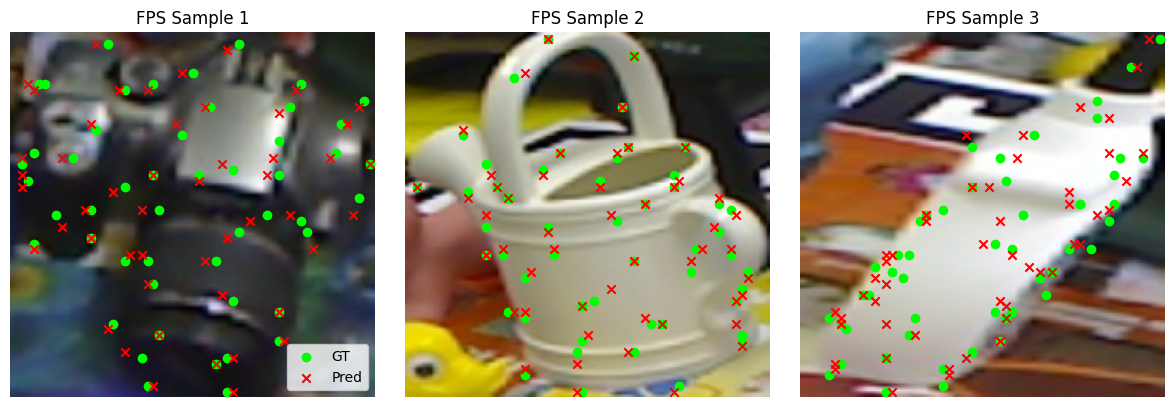


=== Baseline predictions for CPS ===



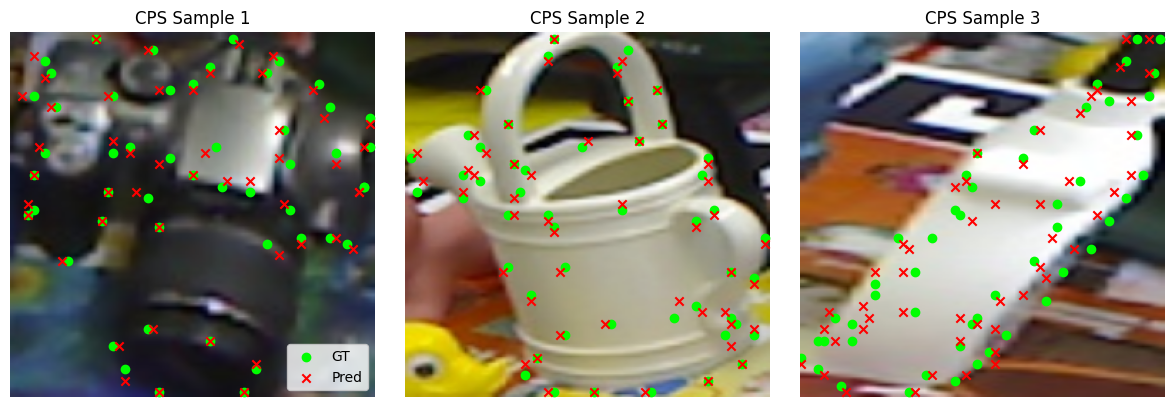

In [ ]:
# Visualize baseline predictions side-by-side for FPS and CPS
for hm in ['fps', 'cps']:
    print(f"\n=== Baseline predictions for {hm.upper()} ===\n")

    # 1) Load the trained baseline model for this heatmap type
    model = KeypointHeatmapNet(num_keypoints=50).to(device)
    ckpt_path = f"/content/drive/MyDrive/MLDL/6D-Pose-Estimation/models/resnet/baseline_{hm}_model.pth"
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.eval()

    # 2) Prepare validation loader for this heatmap type
    ds = make_dataset(hm)
    _, val_loader = make_loaders(ds)

    # 3) Run one batch
    imgs_batch, gt_hm_batch = next(iter(val_loader))
    with torch.no_grad():
        pred_hm_batch = model(imgs_batch.to(device)).cpu()

    # 4) Plot first 3 samples in a row
    n = min(3, imgs_batch.size(0))
    fig, axes = plt.subplots(1, n, figsize=(4 * n, 4))
    if n == 1:
        axes = [axes]

    for i, ax in enumerate(axes):
        img_np = denormalize_rgb(imgs_batch[i])
        gt_pts = get_keypoints_from_heatmaps(gt_hm_batch[i].cpu().numpy()) * 4
        pr_pts = get_keypoints_from_heatmaps(pred_hm_batch[i].numpy()) * 4

        ax.imshow(img_np)
        ax.scatter(gt_pts[:, 0], gt_pts[:, 1], c='lime', marker='o', label='GT')
        ax.scatter(pr_pts[:, 0], pr_pts[:, 1], c='red',  marker='x', label='Pred')
        ax.set_title(f"{hm.upper()} Sample {i+1}")
        ax.axis('off')
        if i == 0:
            ax.legend(loc='lower right')

    plt.tight_layout()
    plt.show()
